## Preliminary

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import Counter
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from keras.layers import Embedding, Bidirectional, CuDNNLSTM, GlobalMaxPooling1D
from keras.regularizers import l2
from keras.models import Model, Sequential
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report


##Text Preprocessing

In [2]:
codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

In [3]:
def create_dict(codes):
  char_dict = {}
  for index, val in enumerate(codes):
    char_dict[val] = index+1

  return char_dict

In [4]:
char_dict = create_dict(codes)

In [5]:
print(char_dict)
print("Dict Length:", len(char_dict))

{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}
Dict Length: 20


In [6]:
def integer_encoding(data):
  """
  - Encodes code sequence to integer values.
  - 20 common amino acids are taken into consideration
    and rest 4 are categorized as 0.
  """
  
  encode_list = []
  for row in data['sequence'].values:
    row_encode = []
    for code in row:
      row_encode.append(char_dict.get(code, 0))
    encode_list.append(np.array(row_encode))
  
  return encode_list

In [7]:
def read_data(partition):
  data = []
  for fn in os.listdir(os.path.join(data_path, partition)):
    with open(os.path.join(data_path, partition, fn)) as f:
      data.append(pd.read_csv(f, index_col=None))
  return pd.concat(data)

In [8]:
!git clone https://github.com/33220311/Extremophiles
datasetFolderPath = '/content/Extremophiles/'
TrainFilePath = os.path.join(datasetFolderPath, 'linTrainTrunc.csv')
TestFilePath = os.path.join(datasetFolderPath, 'linTest.csv')

Cloning into 'Extremophiles'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 94 (delta 12), reused 0 (delta 0), pack-reused 54
Unpacking objects: 100% (94/94), done.


In [9]:
df_train = pd.read_csv(TrainFilePath,names=['sequence','label'],skiprows=1)
df_val = pd.read_csv(TestFilePath,names=['sequence','label'],skiprows=1)

In [10]:
df_train.head()

,sequence,label
0,MQKIKLTGLSLIISGLLMAQAQAAEPVYPDQLRLFSLGQGVCGDKY...,0
1,MHKKTLLATLILGLLAGQAVAAPYLPLASDHRNGEVQTASNAWLEV...,0
2,MSSQHFQGRFEVEFKYRLSDVDAFTCALAALNPEVMLEDNQEQDSY...,0
3,MKKIVVLLGMLLAPWFSSAVQAKGEAGEFDYYAMALSWSPEHCAIK...,0
4,MKKKLIYAAVVSALLAGCGGSDDNKGDTSSYLDYLLTGSNAVGPSA...,0


In [11]:
df_val.head()

,sequence,label
0,MMKGWMKCGLAGAVVLMASFWGGSVRAAGMSLTQVSGPVYVVEDNY...,0
1,MSGKARLHYPVTRQSEQLDHYFGQAVADPYRWLEDDRSPETEAWVK...,0
2,MAKADFYETLGVSKTADEKELKSAFRKLAMKYHPDKNPDDADSERK...,0
3,MNVLSVSSEIYPLIKTGGLADVVGALPIALEAHGVRTRTLIPGYPA...,0
4,MDYSQLMGFGPDGWGYDMLRATAMTMAVAFSGFTIGLVFGCLGAAA...,0


In [12]:
df_train['seq_char_count']= df_train['sequence'].apply(lambda x: len(x))
df_val['seq_char_count']= df_val['sequence'].apply(lambda x: len(x))

In [13]:
def get_code_freq(df, data_name):
  
  df = df.apply(lambda x: " ".join(x))
  
  codes = []
  for i in df: # concatination of all codes
    codes.extend(i)

  codes_dict= Counter(codes)
  codes_dict.pop(' ') # removing white space
  
  print(f'Codes: {data_name}')
  print(f'Total unique codes: {len(codes_dict.keys())}')

  df = pd.DataFrame({'Code': list(codes_dict.keys()), 'Freq': list(codes_dict.values())})
  return df.sort_values('Freq', ascending=False).reset_index()[['Code', 'Freq']]

In [14]:
# train code sequence
train_code_freq = get_code_freq(df_train['sequence'], 'Train')

# val code sequence
val_code_freq = get_code_freq(df_val['sequence'], 'Val')

Codes: Train
Total unique codes: 20
Codes: Val
Total unique codes: 20


In [15]:
train_encode = integer_encoding(df_train) 
val_encode = integer_encoding(df_val) 

In [16]:
train_encode

[array([11, 14,  9,  8,  9, 10, 17,  6, 10, 16, 10,  8,  8, 16,  6, 10, 10,
        11,  1, 14,  1, 14,  1,  1,  4, 13, 18, 20, 13,  3, 14, 10, 15, 10,
         5, 16, 10,  6, 14,  6, 18,  2,  6,  3,  9, 20, 15, 13, 18, 12, 15,
         4,  4,  1, 14, 16, 18,  9, 16, 12,  8, 18,  6, 11, 11,  6, 14, 19,
        14,  8, 16,  6, 10,  1, 12,  6, 19, 18,  8, 11,  6, 13,  6, 20, 12,
         6,  4,  8,  9, 13,  6, 17,  1, 16, 12, 17, 19,  2, 20, 13, 17, 12,
        13, 18, 17,  6,  4,  8, 13, 17, 10, 16,  1, 10,  3,  8, 13,  3,  6,
         3,  4, 18,  3, 18, 14, 19, 15, 10, 18,  7,  3, 16,  1, 12,  5,  8,
         9, 13, 17, 16, 20, 10,  1,  7, 20, 10,  6, 20,  1, 19, 18,  6,  6,
        12,  7, 16, 14, 20, 18,  6,  4,  3, 11,  3, 18, 17, 15,  3,  6,  3,
         6, 19, 18,  8, 15,  6, 12, 12,  3,  6,  6,  2,  3,  6, 20, 15,  2,
         6,  3,  9, 17,  1,  8,  9, 18, 16, 12,  5,  1, 20, 12, 10,  3, 13,
         3, 16,  5,  9,  7,  6,  3, 18, 17, 14, 16,  3, 15, 14, 10, 18,  9,
        17, 

In [17]:
max_length = 100
train_pad = pad_sequences(train_encode, maxlen=max_length, padding='post', truncating='post')
val_pad = pad_sequences(val_encode, maxlen=max_length, padding='post', truncating='post')

In [18]:
print(train_pad.shape, val_pad.shape)

(2213, 100) (562, 100)


In [19]:
# One hot encoding of sequences
train_ohe = to_categorical(train_pad)
val_ohe = to_categorical(val_pad)

In [20]:
# label/integer encoding output variable: (y)
le = LabelEncoder()

y_train_le = le.fit_transform(df_train['label'])
y_val_le = le.transform(df_val['label'])

In [21]:
print(y_train_le)
print(y_train_le.shape)

[0 0 0 ... 1 1 1]
(2213,)


In [22]:
#y_train = to_categorical(y_train_le)
#y_train = np.asarray(y_train_le).astype('float32').reshape((-1,1))
#y_train = tf.one_hot(y_train_le, depth=2)
y_train = y_train_le


In [23]:
y_train

array([0, 0, 0, ..., 1, 1, 1])

In [24]:
#y_val = to_categorical(y_val_le)
#y_val = np.asarray(y_val_le).astype('float32').reshape((-1,1))
#y_val = tf.one_hot(y_val_le, depth=2)
y_val = y_val_le

In [25]:
print(y_train.shape, y_val.shape)

(2213,) (562,)


## Utility Function

In [26]:
# Utility function: plot model's accuracy and loss

# https://realpython.com/python-keras-text-classification/
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

In [27]:
# Utility function: Display model score(Loss & Accuracy) across all sets.

def display_model_score(model, train, val, test, batch_size):

  train_score = model.evaluate(train[0], train[1], batch_size=batch_size, verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[1])
  print('-'*70)

  val_score = model.evaluate(val[0], val[1], batch_size=batch_size, verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[1])
  print('-'*70)
  
  test_score = model.evaluate(test[0], test[1], batch_size=batch_size, verbose=1)
  print('Test loss: ', test_score[0])
  print('Test accuracy: ', test_score[1])

## Klasifikasi

### Multi Layer Perceptron

In [28]:
model = Sequential([        
        Dense(len(train_pad) , activation='relu', name='hidden_1', input_dim=100),
        Dropout(0.2),
        Dense(int(len(train_pad) / 2), activation='relu', name='hidden_2'),
        Dropout(0.2),
        Dense(int(len(train_pad) / 2), activation='relu', name='hidden_3'),
        Dropout(0.2),
        Dense(int(len(train_pad) / 2), activation='relu', name='hidden_4'),
        Dropout(0.2),
        #Dense(int(len(train_pad) / 2), activation='tanh', name='hidden_5'),
        #Dropout(0.3),
        Dense(int(len(train_pad) / 2), activation='relu', name='outer'),
        Dropout(0.2),
        Dense(1, activation='sigmoid'),
    ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_1 (Dense)            (None, 2213)              223513    
                                                                 
 dropout (Dropout)           (None, 2213)              0         
                                                                 
 hidden_2 (Dense)            (None, 1106)              2448684   
                                                                 
 dropout_1 (Dropout)         (None, 1106)              0         
                                                                 
 hidden_3 (Dense)            (None, 1106)              1224342   
                                                                 
 dropout_2 (Dropout)         (None, 1106)              0         
                                                                 
 hidden_4 (Dense)            (None, 1106)              1

In [29]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [30]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy', #tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )

In [31]:
y_train.shape, y_val.shape

((2213,), (562,))

In [32]:
 history = model.fit(
     train_pad, y_train,
     epochs=1000, batch_size=60,
     validation_data=(val_pad, y_val)
   #  callbacks=[es]
     )

Epoch 1/1000
37/37 [==============================] - 4s 9ms/step - loss: 0.8310 - accuracy: 0.5066 - val_loss: 0.7001 - val_accuracy: 0.5214
Epoch 2/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.7303 - accuracy: 0.5269 - val_loss: 0.6863 - val_accuracy: 0.5623
Epoch 3/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.7104 - accuracy: 0.5472 - val_loss: 0.7046 - val_accuracy: 0.5053
Epoch 4/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.7093 - accuracy: 0.5481 - val_loss: 0.6942 - val_accuracy: 0.5249
Epoch 5/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.6998 - accuracy: 0.5653 - val_loss: 0.6993 - val_accuracy: 0.5160
Epoch 6/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.6996 - accuracy: 0.5567 - val_loss: 0.6952 - val_accuracy: 0.5445
Epoch 7/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.6800 - accuracy: 0.5766 - val_loss: 0.7549 - val_accuracy: 0.4875
Epoch 

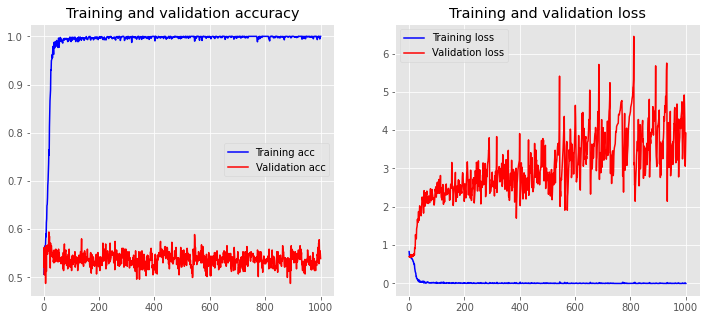

In [33]:
plot_history(history)

In [34]:
 display_model_score(model,
     [train_pad, y_train],
     [val_pad, y_val],
     [val_pad, y_val],
     256)

9/9 [==============================] - 0s 3ms/step - loss: 2.1773e-06 - accuracy: 1.0000
Train loss:  2.177284613935626e-06
Train accuracy:  1.0
----------------------------------------------------------------------
3/3 [==============================] - 0s 3ms/step - loss: 3.9232 - accuracy: 0.5391
Val loss:  3.923175096511841
Val accuracy:  0.5391458868980408
----------------------------------------------------------------------
3/3 [==============================] - 0s 3ms/step - loss: 3.9232 - accuracy: 0.5391
Test loss:  3.923175096511841
Test accuracy:  0.5391458868980408


In [35]:
# saving model weights.
model.save_weights('/content/Extremophiles/MLP1.h5')

In [36]:
y_pred = model.predict(val_pad)

In [37]:
y_pred = np.reshape(y_pred,(len(y_pred),)).astype(int)

In [38]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.99      0.68       289
           1       0.82      0.03      0.06       273

    accuracy                           0.53       562
   macro avg       0.67      0.51      0.37       562
weighted avg       0.67      0.53      0.38       562



### CNN

In [39]:
Y_train = np.reshape(y_train,(len(y_train),1)).astype(int)
Y_test = np.reshape(y_val,(len(y_val),1)).astype(int)

In [40]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dense
from keras.layers import Flatten

In [41]:
n_timesteps, n_features, n_outputs =train_pad.shape[0], train_pad.shape[1], Y_train.shape[1]

In [42]:
# Building the CNN Model
cnn_model = Sequential()      # initializing the Sequential nature for CNN model

In [43]:
cnn_model.add(Conv1D(filters=64, kernel_size=2, 
activation='relu',input_shape=(n_features,1)))
cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(250, activation='relu'))
cnn_model.add(Dense(n_outputs, activation='sigmoid'))

In [44]:
cnn_model.compile(loss='binary_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
                  metrics=['accuracy'])

In [45]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 99, 64)            192       
                                                                 
 conv1d_1 (Conv1D)           (None, 98, 64)            8256      
                                                                 
 dropout_5 (Dropout)         (None, 98, 64)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense_1 (Dense)             (None, 250)               784250    
                                                      

In [46]:
es = EarlyStopping(monitor='val_loss', patience=150, verbose=1)

In [47]:
# fit network
history = cnn_model.fit(train_pad, Y_train, 
                        validation_data=(val_pad, Y_test),
                        callbacks=[es],
                        epochs=1000, batch_size=256, verbose=1
                        )

Epoch 1/1000
9/9 [==============================] - 9s 42ms/step - loss: 3.9116 - accuracy: 0.4722 - val_loss: 0.7416 - val_accuracy: 0.4858
Epoch 2/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.7143 - accuracy: 0.5224 - val_loss: 0.7022 - val_accuracy: 0.5142
Epoch 3/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.7056 - accuracy: 0.5151 - val_loss: 0.6940 - val_accuracy: 0.5142
Epoch 4/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.6953 - accuracy: 0.5093 - val_loss: 0.6919 - val_accuracy: 0.5142
Epoch 5/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.6914 - accuracy: 0.5314 - val_loss: 0.6921 - val_accuracy: 0.4982
Epoch 6/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.6914 - accuracy: 0.5133 - val_loss: 0.6904 - val_accuracy: 0.5587
Epoch 7/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.6897 - accuracy: 0.5355 - val_loss: 0.6892 - val_accuracy: 0.5196
Epoch 8/1000
9/9 [=

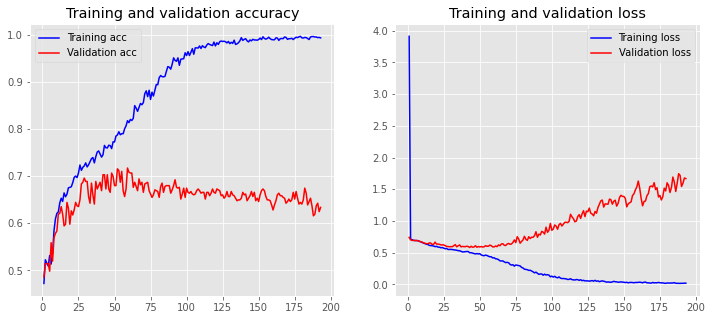

In [48]:
plot_history(history)

In [49]:
display_model_score(cnn_model,
    [train_pad, Y_train],
    [val_pad, Y_test],
    [val_pad, Y_test],
    256)

9/9 [==============================] - 0s 3ms/step - loss: 0.0018 - accuracy: 1.0000
Train loss:  0.0018187933601439
Train accuracy:  1.0
----------------------------------------------------------------------
3/3 [==============================] - 0s 3ms/step - loss: 1.6689 - accuracy: 0.6335
Val loss:  1.6688674688339233
Val accuracy:  0.6334519386291504
----------------------------------------------------------------------
3/3 [==============================] - 0s 3ms/step - loss: 1.6689 - accuracy: 0.6335
Test loss:  1.6688674688339233
Test accuracy:  0.6334519386291504


In [50]:
y_pred = cnn_model.predict(val_pad)

In [51]:
y_pred = np.reshape(y_pred,(len(y_pred),)).astype(int)

In [52]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.52      1.00      0.68       289
           1       1.00      0.00      0.01       273

    accuracy                           0.52       562
   macro avg       0.76      0.50      0.34       562
weighted avg       0.75      0.52      0.35       562



### Bi-LSTM

In [95]:
x_input = Input(shape=(100,))
emb = Embedding(21, 128, input_length=max_length)(x_input)
bi_rnn = Bidirectional(CuDNNLSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))(emb)
x = Dropout(0.3)(bi_rnn)

# softmax classifier
x_output = Dense(1, activation='sigmoid')(x)

model1 = Model(inputs=x_input, outputs=x_output)

In [96]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
               loss='binary_crossentropy', 
               metrics=['accuracy'])

In [97]:
model1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 100, 128)          2688      
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              99328     
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 102,145
Trainable params: 102,145
Non-trainable params: 0
_____________________________________________________

In [98]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=150, verbose=1)

In [99]:
history1 = model1.fit(
    train_pad, y_train,
    epochs=1000, batch_size=256,
    validation_data=(val_pad, y_val),
    callbacks=[es]
    )

Epoch 1/1000
9/9 [==============================] - 2s 62ms/step - loss: 6.2334 - accuracy: 0.5097 - val_loss: 5.6848 - val_accuracy: 0.5196
Epoch 2/1000
9/9 [==============================] - 0s 22ms/step - loss: 5.3241 - accuracy: 0.5901 - val_loss: 4.8668 - val_accuracy: 0.6904
Epoch 3/1000
9/9 [==============================] - 0s 21ms/step - loss: 4.5708 - accuracy: 0.7045 - val_loss: 4.1942 - val_accuracy: 0.7242
Epoch 4/1000
9/9 [==============================] - 0s 21ms/step - loss: 3.9519 - accuracy: 0.7090 - val_loss: 3.6355 - val_accuracy: 0.7527
Epoch 5/1000
9/9 [==============================] - 0s 21ms/step - loss: 3.3888 - accuracy: 0.7813 - val_loss: 3.0111 - val_accuracy: 0.8114
Epoch 6/1000
9/9 [==============================] - 0s 21ms/step - loss: 2.8995 - accuracy: 0.8016 - val_loss: 2.6836 - val_accuracy: 0.8505
Epoch 7/1000
9/9 [==============================] - 0s 21ms/step - loss: 2.5645 - accuracy: 0.8183 - val_loss: 2.3475 - val_accuracy: 0.8612
Epoch 8/1000


In [58]:
# saving model weights.
model1.save_weights('/content/Extremophiles/BLSTM1.h5')

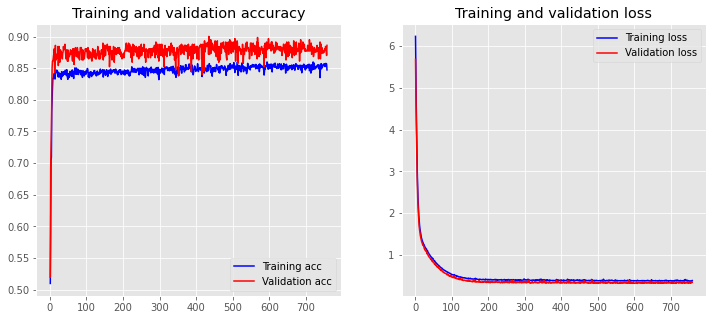

In [100]:
plot_history(history1)

In [101]:
display_model_score(model1,
    [train_pad, y_train],
    [val_pad, y_val],
    [val_pad, y_val],
    256)

9/9 [==============================] - 0s 8ms/step - loss: 0.3876 - accuracy: 0.8459
Train loss:  0.3876338005065918
Train accuracy:  0.8459105491638184
----------------------------------------------------------------------
3/3 [==============================] - 0s 7ms/step - loss: 0.3467 - accuracy: 0.8861
Val loss:  0.346744567155838
Val accuracy:  0.8861209750175476
----------------------------------------------------------------------
3/3 [==============================] - 0s 7ms/step - loss: 0.3467 - accuracy: 0.8861
Test loss:  0.346744567155838
Test accuracy:  0.8861209750175476


In [102]:
y_pred = model1.predict(val_pad)

In [103]:
y_pred = np.reshape(y_pred,(len(y_pred),)).astype(int)

In [104]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.51      1.00      0.68       289
           1       0.00      0.00      0.00       273

    accuracy                           0.51       562
   macro avg       0.26      0.50      0.34       562
weighted avg       0.26      0.51      0.35       562



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Grid Search

In [64]:
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV

In [65]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(2213,1106,1106,1106,1106),
                        max_iter = 300,activation = 'relu',
                        solver = 'adam', alpha=0.0001, batch_size=256, learning_rate_init=0.0001,
                        learning_rate='constant', momentum=0.9, early_stopping=True)

In [66]:
mlp_clf.fit(train_pad, y_train)

MLPClassifier(batch_size=256, early_stopping=True,
              hidden_layer_sizes=(2213, 1106, 1106, 1106, 1106),
              learning_rate_init=0.0001, max_iter=300)

In [67]:
y_pred = mlp_clf.predict(val_pad)

print('Accuracy: {:.2f}'.format(accuracy_score(y_val, y_pred)))

Accuracy: 0.54


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


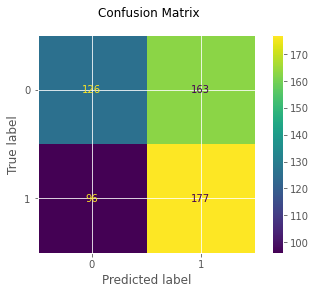

In [68]:
fig = plot_confusion_matrix(mlp_clf, val_pad, y_val, display_labels=mlp_clf.classes_)
fig.figure_.suptitle("Confusion Matrix")
plt.show()

In [69]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.44      0.49       289
           1       0.52      0.65      0.58       273

    accuracy                           0.54       562
   macro avg       0.54      0.54      0.54       562
weighted avg       0.54      0.54      0.53       562



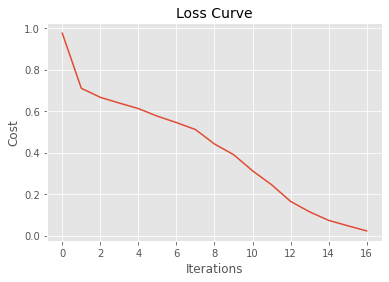

In [70]:
plt.plot(mlp_clf.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [71]:
activation =  ['relu', 'tanh', 'hard_sigmoid', 'linear'] # softmax, softplus, softsign 
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
weight_constraint=[1, 2, 3, 4, 5]
neurons = [1, 5, 10, 15, 20, 25, 30]
init = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
optimizer = [ 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

In [72]:
param_grid = {
    #'hidden_layer_sizes': [(150,100,50), (120,80,40), (100,50,30)],
    'max_iter': [100, 150],
    'activation': ['relu', 'tanh', 'identity', 'logistic' ],
    'solver': ['adam', 'sgd'],
    #'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.05],
    'batch_size': [50,100,150,200],
    'learning_rate': ['constant','adaptive', 'invscaling'],
    'learning_rate_init': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.05],
    #'momentum' : [0.0, 0.2, 0.4, 0.6, 0.8, 0.9],
    #'early_stopping':[True,False],
    #'dropout_rate' : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    #'weight_constraint':[1, 2, 3, 4, 5],
    #'init' : ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'],
}

In [73]:
grid = GridSearchCV(mlp_clf, param_grid, n_jobs= -1, cv=5)
grid.fit(train_pad, y_train)

print(grid.best_params_) 

KeyboardInterrupt: ignored

In [ ]:
grid_predictions = grid.predict(val_pad) 

print('Accuracy: {:.2f}'.format(accuracy_score(y_val, grid_predictions)))